# Setup python environment using keras and tensorflow

In [113]:
# To determine which version you're using:
#!pip show tensorflow

# For the current version: 
#!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==2.0.0-alpha0 

import matplotlib.pyplot as plt
from time import time
import numpy as np
import keras
from keras.models import Model, Sequential
from keras.layers import Add, Input, Dense, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Activation
from keras.callbacks import TensorBoard
import math as m
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip show tensorflow

Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Applications/anaconda3/lib/python3.7/site-packages
Requires: astor, opt-einsum, protobuf, google-pasta, numpy, absl-py, keras-preprocessing, keras-applications, termcolor, wheel, tensorflow-estimator, six, wrapt, tensorboard, gast, grpcio
Required-by: 


# Create function for ghost model

In [2]:
#Function to model ghost function
#input parameters
#nx    - number of spatial samples
#nfreq - number of frequency samples
#df    - frequency sampling
#depth - the depth of sources and receivers 
#c     - propagation velocity in water
#output parameter
#G     - ghost model in frequency domain according to matrix notation
def GhostMod(nx,dx,nfreq,df,depth,c):
    omega=2.0*m.pi*df*np.arange(0,nfreq)

    k_x=np.hstack((np.arange(0,(nx/2)+1),np.arange(-(nx/2)+1,0)))*2*m.pi/nx/dx
    [fk_k,fk_f]=np.complex64(np.meshgrid(k_x, omega))

    kz=np.sqrt(fk_f*fk_f/(c*c)-fk_k*fk_k)
    G=np.ones((fk_k.shape[0],fk_f.shape[1]))-0.99*np.exp(-1j*2*depth*np.conj(kz))

    return G

# Load binary data and apply Fourier transforms

In [59]:
#The number of receivers and sources
nrec=480
nsrc=480
#Spatial sampling
dx=12.5
#Time samples and sampling
nt=480
dt=0.004
#Frequency sampling
df=1/(nt*dt)
#Maximum frequency and number of frequencies to view in plots
fmax=60
nfreq=int(fmax/df)+1
#Read in seismic data and reshape to matrix notation (binary format)
p=np.reshape(np.fromfile('/Users/jwvrolijk/Seismics/MASTERCLASS/shots.P0.bin', dtype=np.float32, count=-1, sep=''),[nsrc,nrec,nt]).T
#Apply Fourier transform over time axis
P=np.fft.rfft(p,axis=0)
#Apply Fourier transform over spatial axes
Pk=np.fft.fft(np.fft.fft(P,axis=1),axis=2)
print(np.min(p))

-0.005127293


# Plot data

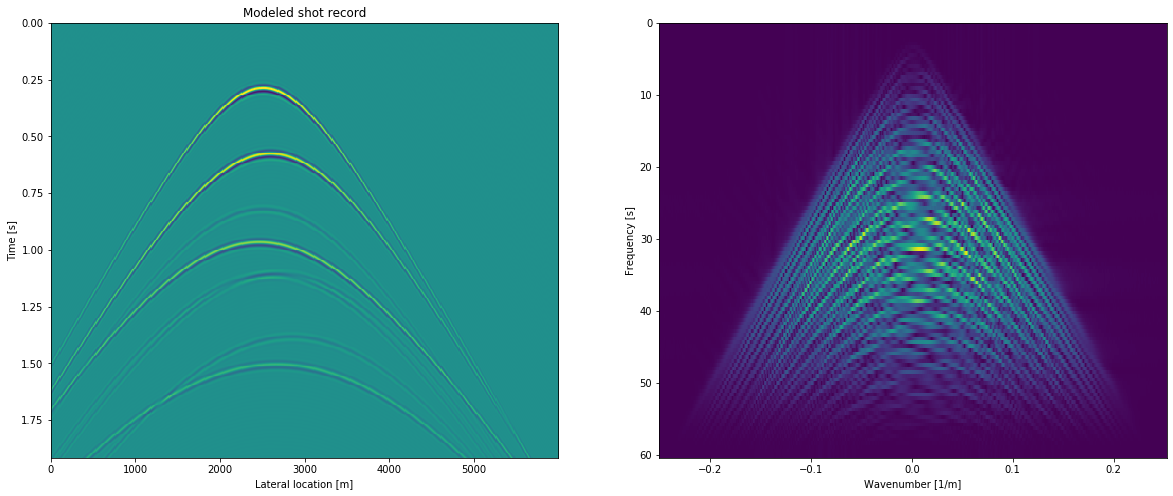

In [62]:
#Check shot number #maximum 
shot=200

#sampling in wavenumber domain
dkx=2*m.pi/nrec/dx

#Plot shot record in time space and wavenumber frequency domain
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(p[:,:,shot],extent=[0,dx*(nrec-1),dt*(nt-1),0],vmin=-3e-3,vmax=3e-3,aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Modeled shot record')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(P[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1,aspect='auto')
ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()

# Add ghost to model

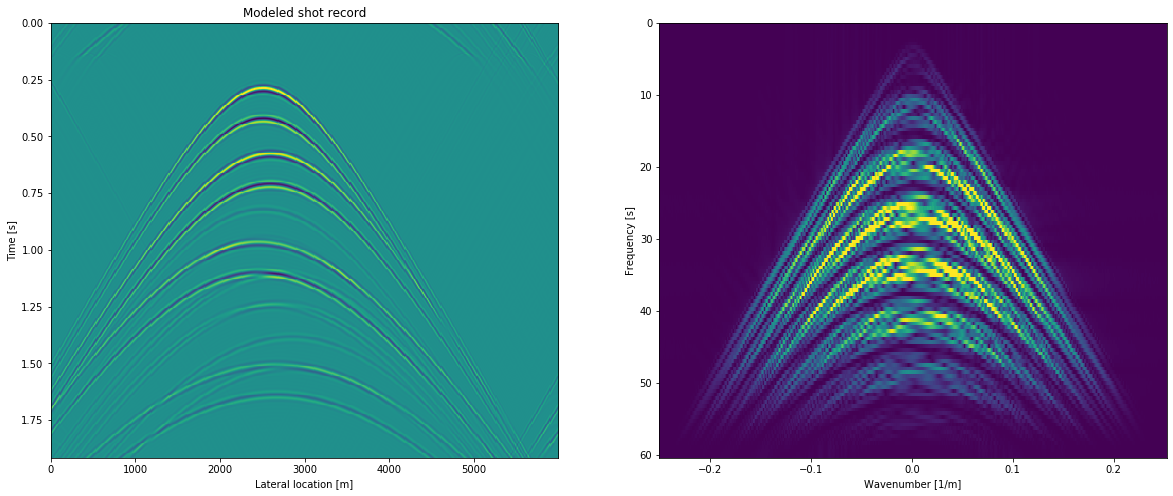

In [63]:
#Set depth of receivers
depth=100
#Set propagation velocity
c=1500
#Create ghost model
G=GhostMod(nrec,dx,(nt/2)+1,df,depth,c)

#Apply ghost model to data 
GP=np.fft.ifft(np.einsum('ij,ijk->ijk',G,np.fft.fft(P,axis=1)),axis=1)

#Plot shot record including ghost in time space and wavenumber frequency domain
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.fft.irfft(GP[:,:,shot],axis=0),extent=[0,dx*(nrec-1),dt*(nt-1),0],vmin=-3e-3,vmax=3e-3,aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Modeled shot record')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(GP[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1,aspect='auto')
ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')

plt.show()


# Subsample data

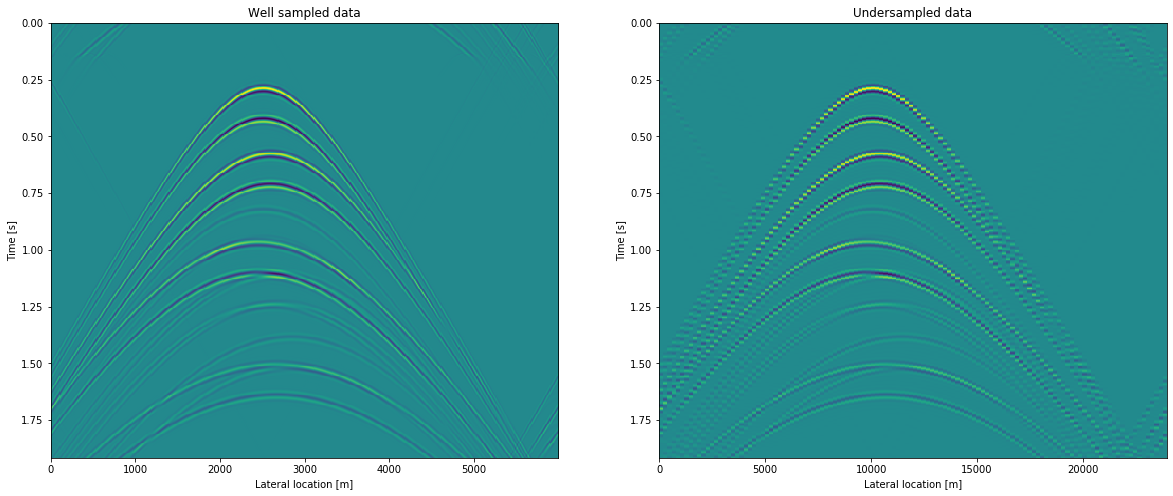

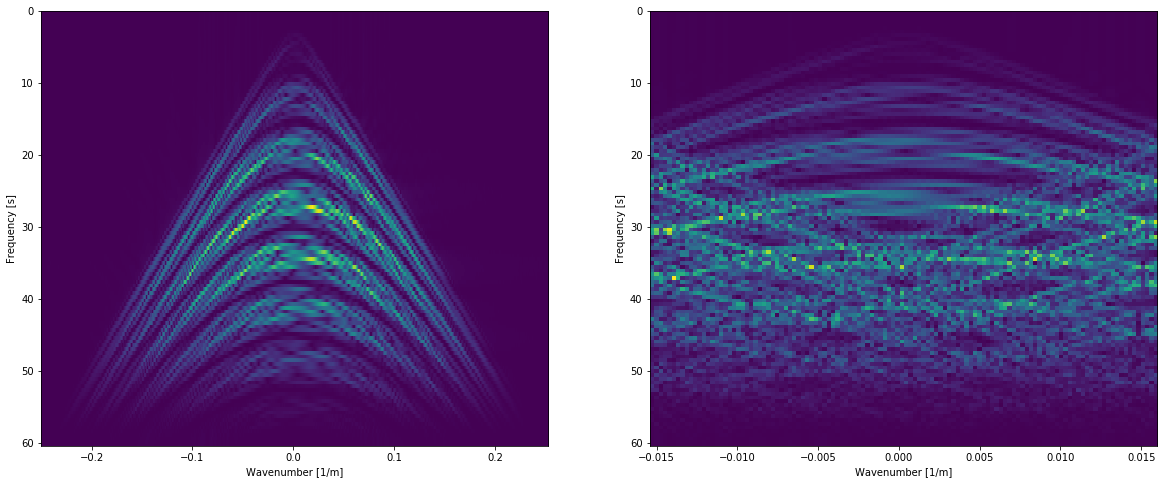

In [93]:
#Subsampling receiver factor (4/8)
factor=4

#Spatial sampling after subsampling
dxsub=dx*factor
nsub=int(nrec/factor)
dksub=2*m.pi/nsrc/dxsub

#Subsample the shot records including the ghost
GPsub=GP[:,0::factor,:]

#Plot shot record vs subsampled shot record in time space and wavenumber frequency domain
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.fft.irfft(GP[:,:,shot],axis=0),extent=[0,dx*(nrec-1),dt*(nt-1),0],aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Well sampled data')

ax2.imshow(np.fft.irfft(GPsub[:,:,shot],axis=0),extent=[0,dxsub*(nsrc-1),dt*(nt-1),0],aspect='auto')
ax2.axis([0,(nsrc-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Undersampled data')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(GP[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],aspect='auto')
ax1.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax1.set_xlabel('Wavenumber [1/m]')
ax1.set_ylabel('Frequency [s]')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(GPsub[:,:,shot],axis=1),axes=1)),extent=[-((nsub/2)+1)*dksub,((nsub/2)+1)*dksub,df*(nt/2),0],aspect='auto')
ax2.axis([(-(nsub/2)+1)*dksub,((nsub/2)+1)*dksub,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()


# Deghost data


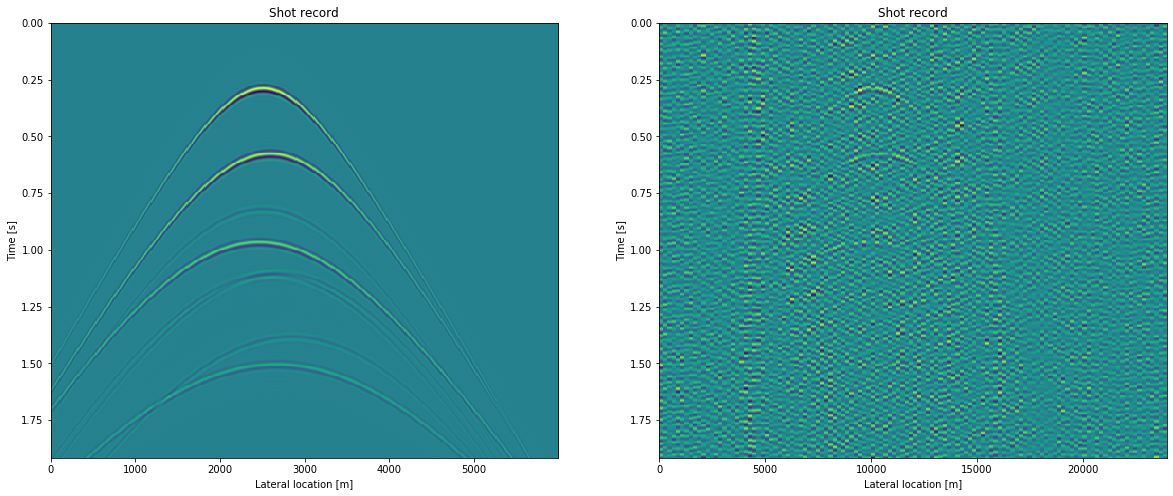

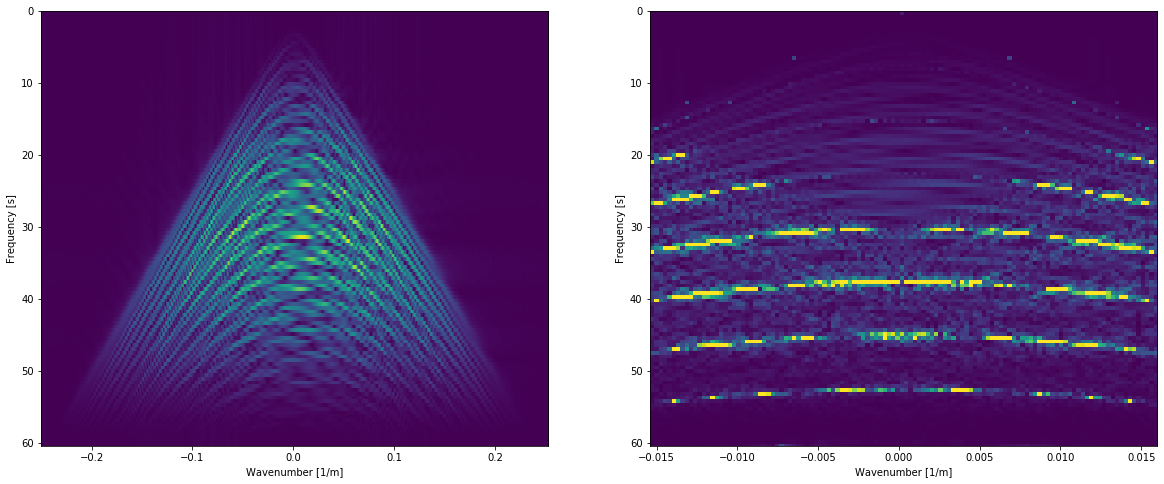

In [95]:
#Apply deghosting to well-sampled data
Ymeas=np.fft.ifft(np.einsum('ij,ijk->ijk',(1/G),np.fft.fft(GP,axis=1)),axis=1)

#Apply deghosting to subsampled data
Gsub=GhostMod(nsub,dxsub,nt/2+1,df,depth,c)
Ysub=np.fft.ifft(np.einsum('ij,ijk->ijk',(1/Gsub),np.fft.fft(GPsub,axis=1)),axis=1)

#Plot deghosting results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.fft.irfft(Ymeas[:,:,shot],axis=0),extent=[0,dx*(nrec-1),dt*(nt-1),0],aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Shot record')

ax2.imshow(np.fft.irfft(Ysub[:,:,shot],axis=0),extent=[0,dxsub*(nsrc-1),dt*(nt-1),0],aspect='auto')
ax2.axis([0,(nsrc-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Shot record')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Ymeas[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1,aspect='auto')
ax1.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax1.set_xlabel('Wavenumber [1/m]')
ax1.set_ylabel('Frequency [s]')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Ysub[:,:,shot],axis=1),axes=1)),extent=[-((nsub/2)+1)*dksub,((nsub/2)+1)*dksub,df*(nt/2),0],vmin=0,vmax=1,aspect='auto')
ax2.axis([(-(nsub/2)+1)*dksub,((nsub/2)+1)*dksub,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()

# Split subsampled data in training data (even shots) and validation data (odd shots)


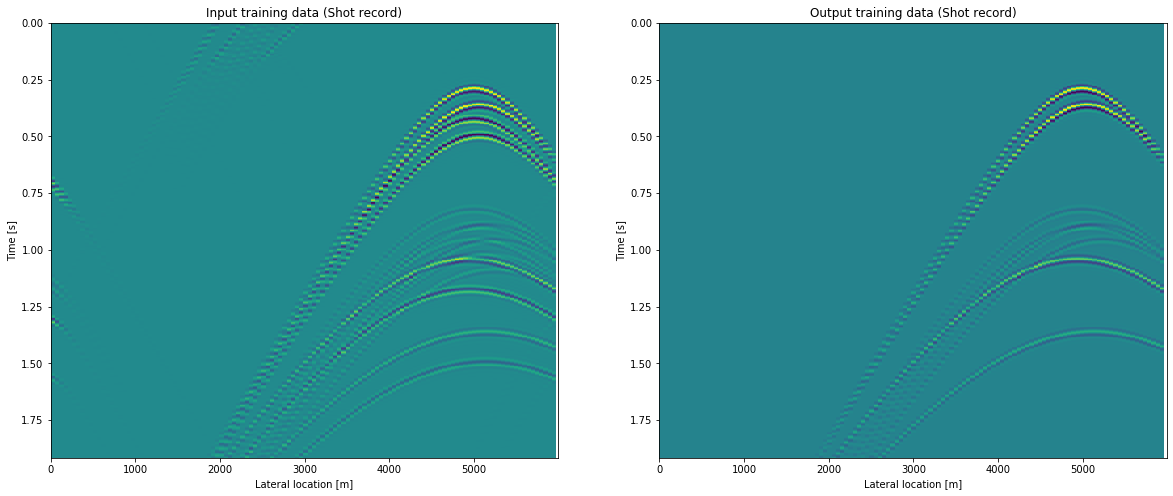

In [96]:
#Apply inverse fourier transform to data including and excluding ghost
ymeas=np.fft.irfft(Ymeas,axis=0)
xmeas=np.fft.irfft(GP,axis=0)

#Subsampled data before and after deghosting
y= np.empty((nt,nsub,0), int)
x= np.empty((nt,nsub,0), int)
y=ymeas[:,0::factor,:]
x=xmeas[:,0::factor,:]

#even numbers are training data #odd records are validation data
ytrain=y[:,:,0::2]
xtrain=x[:,:,0::2]
yval=y[:,:,1::2]
xval=x[:,:,1::2]

#Plot training data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(xtrain[:,:,shot],extent=[0,dxsub*(nsub-1),dt*(nt-1),0],aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Input training data (Shot record)')

ax2.imshow(ytrain[:,:,shot],extent=[0,dxsub*(nsub-1),dt*(nt-1),0],aspect='auto')
ax2.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Output training data (Shot record)')
plt.show()

#fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
#ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Xtrain[:,:,1],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],aspect='auto')
#ax1.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
#ax1.set_xlabel('Wavenumber [1/m]')
#ax1.set_ylabel('Frequency [s]')

#ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Ytrain[:,:,1],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],aspect='auto')
#ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
#ax2.set_xlabel('Wavenumber [1/m]')
#ax2.set_ylabel('Frequency [s]')
#plt.show()

# Prepare data for learning


In [97]:
#normalize training data before feeding in to neural network
mean = np.mean(xtrain,axis=(1,2))
mean = mean[:, np.newaxis, np.newaxis]
std = np.std(xtrain,axis=(1,2))
std = std[:, np.newaxis, np.newaxis]

xtrain-=mean
xtrain/=std
ytrain-=mean
ytrain/=std

#re-arrange training data to tensorflow neural network format (training sets/shots, time samples, spatial samples, 1)
xtrain = np.moveaxis(xtrain, -1, 0)
ytrain = np.moveaxis(ytrain, -1, 0)
xtrain = xtrain[:, :, :, np.newaxis]
ytrain = ytrain[:, :, :, np.newaxis]

#normalize validation data before feeding in to neural network
mean = np.mean(xval,axis=(1,2))
mean = mean[:, np.newaxis, np.newaxis]
std = np.std(xval,axis=(1,2))
std = std[:, np.newaxis, np.newaxis]

xval-=mean
xval/=std
yval-=mean
yval/=std

#normalize validation data before feeding in to neural network
xval = np.moveaxis(xval, -1, 0)
yval = np.moveaxis(yval, -1, 0)
xval = xval[:, :, :, np.newaxis]
yval = yval[:, :, :, np.newaxis]


In [98]:
# Build 4 layer encoding-decoding network
# (1 encoding layers - 1 connecting layer - 1 decoding layers - 1 output layer)
def Encoding_Decoding1(nt,nx,nfilter):
    inputs = Input((nt, nx, 1))

    #create encoding layer
    c1 = Conv2D(nfilter, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    #connecting layer
    c2 = Conv2D(nfilter*2, (3, 3), padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    #create decoding layer
    u3 = Conv2DTranspose(nfilter, (2, 2), strides=(2, 2), padding='same') (c2)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Add()([u3, c1])

    #create output layer
    outputs = Conv2D(1, (1, 1)) (u3)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [99]:
model1=Encoding_Decoding1(nt,nsub,8)
model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 480, 120, 1)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 480, 120, 8)  80          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 480, 120, 8)  32          conv2d_18[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 480, 120, 8)  0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [100]:
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(xtrain, ytrain,
                epochs=5,
                batch_size=1,
                shuffle=True,validation_data=(xval,yval))

Train on 240 samples, validate on 240 samples
Epoch 1/5
240/240 [==============================] - 60s 251ms/step - loss: 0.3860 - val_loss: 0.2472
Epoch 2/5
240/240 [==============================] - 55s 229ms/step - loss: 0.2094 - val_loss: 0.1895
Epoch 3/5
240/240 [==============================] - 58s 242ms/step - loss: 0.1738 - val_loss: 0.1608
Epoch 4/5
240/240 [==============================] - 54s 227ms/step - loss: 0.1549 - val_loss: 0.1458
Epoch 5/5
240/240 [==============================] - 54s 227ms/step - loss: 0.1415 - val_loss: 0.1344


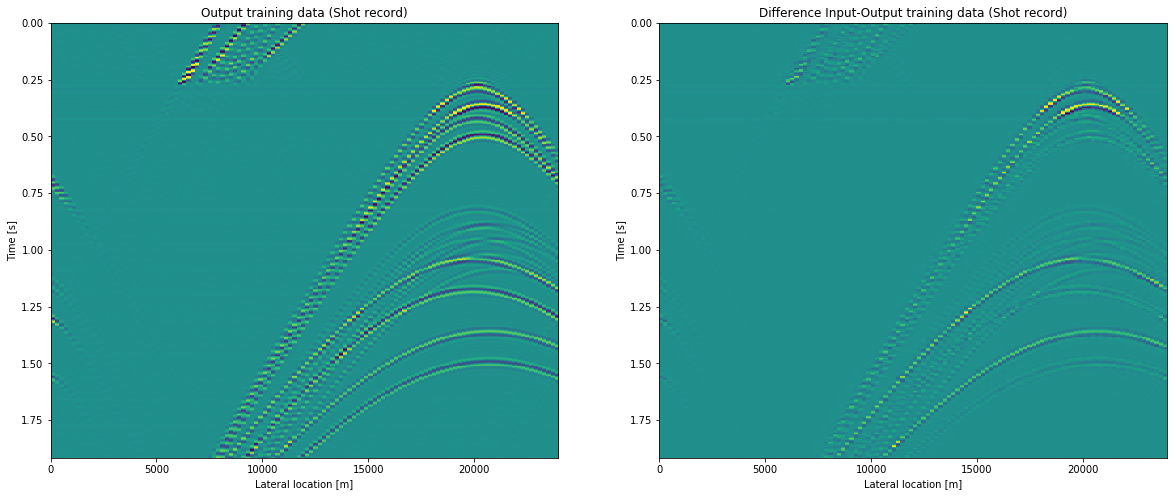

In [101]:
ypred = model1.predict(xval)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(xval[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax1.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Output training data (Shot record)')
ax2.imshow(ypred[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax2.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Difference Input-Output training data (Shot record)')
plt.show()

In [114]:
# Build 8 layer encoding-decoding network
# (3 encoding layers - 1 connecting layer - 3 decoding layers - 1 output layer)
def Encoding_Decoding3(nt,nx,nfilter):

    # Create a new model instance
    #model = create_model()
    inputs = Input((nt, nx, 1))

    c1 = Conv2D(nfilter, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(nfilter*2, (3, 3), padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(nfilter*3, (3, 3), padding='same') (p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(nfilter*4, (3, 3), padding='same') (p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(nfilter*3, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)
    u5 = Add()([u5, c3])

    u6 = Conv2DTranspose(nfilter*2, (2, 2), strides=(2, 2), padding='same') (u5)
    u6 = BatchNormalization()(u6)
    u6 = Activation('relu')(u6)
    u6 = Add()([u6, c2])

    u7 = Conv2DTranspose(nfilter, (2, 2), strides=(2, 2), padding='same') (u6)
    u7 = BatchNormalization()(u7)
    u7 = Activation('relu')(u7)
    u7 = Add()([u7, c1])

    outputs = Conv2D(1, (1, 1)) (u7)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [115]:
model_deep = Encoding_Decoding3(nt,nsub,32)
model_deep.summary()
model_deep.compile(optimizer='adam', loss='mean_squared_error')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 480, 120, 1)  0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 480, 120, 32) 320         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 480, 120, 32) 128         conv2d_61[0][0]                  
__________________________________________________________________________________________________
activation_79 (Activation)      (None, 480, 120, 32) 0           batch_normalization_79[0][0]     
___________________________________________________________________________________________

In [116]:
model_deep.fit(xtrain, ytrain,
                epochs=5,
                batch_size=1,
                shuffle=True,validation_data=(xval,yval), callbacks=[tensorboard])

Train on 240 samples, validate on 240 samples
Epoch 1/5
240/240 [==============================] - 368s 2s/step - loss: 0.2485 - val_loss: 0.2317
Epoch 2/5
240/240 [==============================] - 458s 2s/step - loss: 0.1020 - val_loss: 0.0884
Epoch 3/5
240/240 [==============================] - 463s 2s/step - loss: 0.0680 - val_loss: 0.0601
Epoch 4/5
240/240 [==============================] - 276s 1s/step - loss: 0.0516 - val_loss: 0.0506
Epoch 5/5
240/240 [==============================] - 278s 1s/step - loss: 0.0433 - val_loss: 0.0445


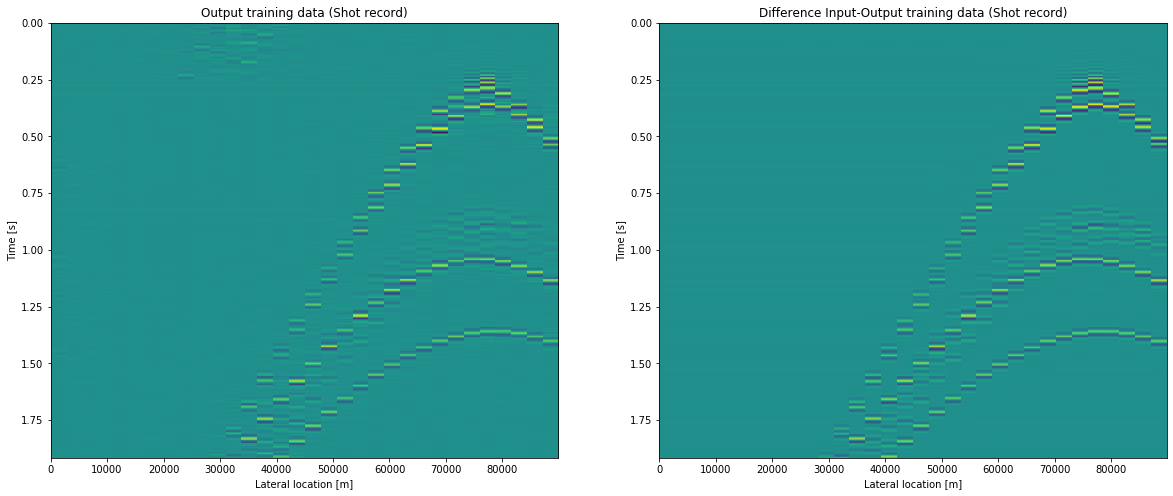

In [21]:
ypred = model_deep.predict(xval)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(ypred[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax1.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Output training data (Shot record)')
ax2.imshow(yval[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax2.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Difference Input-Output training data (Shot record)')
plt.show()